# Logistic model

## Imports

In [3]:
# IMPORT THE NECESSARY LIBRARIES
import pandas as pd
import re # This module provides functions for working with regular expressions allowing search, match and manipulate strings based on patterns
import os # This module allows interaction with the operating system, such as working with files, directories, environment variables, and system commands.
import sys # This module provides access to system-specific parameters, including command-line arguments (sys.argv), standard input/output, and exiting the program (sys.exit()).
import matplotlib.pyplot as plt
import scipy.optimize as opt
from glob import glob

from matplotlib.ticker import MaxNLocator
from statsmodels.graphics.tsaplots import plot_acf # This function is used for plotting the Autocorrelation Function (ACF), which is helpful in time series analysis to measure how observations are correlated with their past values.
from mice_inspection_utils import * # Import all functions 
                                    # NOTICE: this is different from import mice_inspection_utils! In that case you'd have to use the module name as a prefic to access functions, classes or variables. E.g. mice_inspection_utils.some_function()
from scipy.stats import linregress

# This part avoids possible conflict due to the structure of mice_inspection_utils
if not os.path.exists('Data/by_mouse'): 
    os.makedirs('Data/by_mouse')

# GET THE NECESSARY DATA
imput_subj_paths = [f"Data/raw/total.full.rn.RA.total_OTU_table.mouse{i+1}.ovr0.0p.csv" for i in range(0, 8)]
output_subj_paths = [f"Data/by_mouse/mouse_{i+1}.csv" for i in range(0, 8)]
metadata_path = "Data/raw/OTU_table.csv"
mi = Mice_Inspection(ip = imput_subj_paths, op = output_subj_paths, mdp = metadata_path)

## Data structure

In [5]:
# By calling mice_df we have the dataframes for each mouse
df = mi.mice_df[0]
df.head() # -> As we can see we have the bacterial species, the median, the mean counts, and the counts per day (at day 1, 8, 9 ...)

# By calling get_species_df
df = mi.get_species_df(species = 'Prevotella sp. Smarlab 121567')
df.head(20) # -> As we can see we have the count per day of the selected species in each mouse

,day,mouse_1,mouse_2,mouse_3,mouse_4,mouse_5,mouse_6,mouse_7,mouse_8,mean,std
0,0,0,1,0,0,0,0,0,2,0.375,0.744024
1,1,0,0,0,0,0,0,0,1,0.125,0.353553
2,2,0,1,1,0,0,0,0,2,0.500,0.755929
3,3,0,0,0,0,2,0,0,0,0.250,0.707107
4,4,0,0,0,0,0,0,0,0,0.000,0.000000
5,5,0,0,0,0,0,0,0,0,0.000,0.000000
6,6,0,0,0,0,0,0,0,0,0.000,0.000000
7,7,0,0,0,0,0,0,0,0,0.000,0.000000
8,8,0,0,0,0,0,0,0,7,0.875,2.474874
9,9,0,0,9,0,1,60,0,0,8.750,20.940392


## Dissimilarity computation

First of all we create the dataframes with the dissimilarity values for each mouse. 

In [8]:
mice_diss = []
oracle_file = os.path.join(os.getcwd(), "Data" ,"dissimilarities")  

# Run a hyperparameter search using Keras Tuner only if it hasn't been done before. 
if not os.path.exists(oracle_file):
    for mouse in range(1,2): 
        df = mi.get_dissimilarities(mouse, write = True)
        mice_diss.append(df)
    print("Database created")
else:
    for mouse in range(1,9): 
        folder_path = os.path.join(oracle_file, f"dissimilarity_{mouse}.csv")
        csv_files = glob(folder_path )  # Get all CSV file in folder
        df_list = [pd.read_csv(file,index_col=0)  for file in csv_files]   # Read and merge all files
        mice_diss.append(pd.concat(df_list,ignore_index=False))
        
    print("Data take from files; if you want to compute again delete folder")

Data take from files; if you want to compute again delete folder


Let's now have a graphical visualization of these dissimilarities

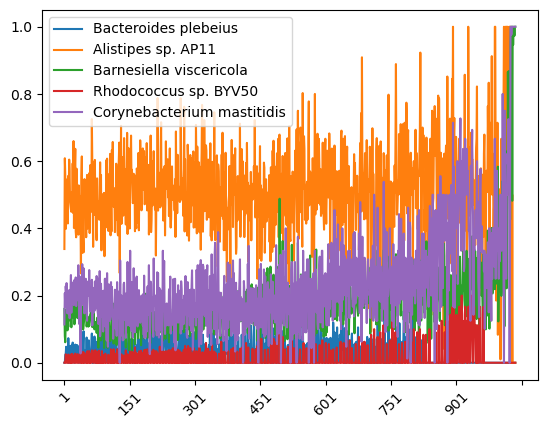

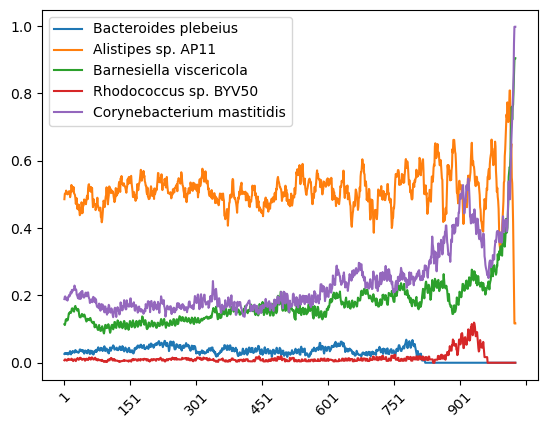

In [10]:
# For the first mice (mice_diss[0])
species = np.asarray(mice_diss[0].index)
n_species = 5
rnd_idx = np.random.choice(np.arange(len(species)), n_species)
species = species[rnd_idx]
lags = np.asarray(mice_diss[0].columns)

for sp in species: 
    data = mice_diss[0].loc[sp].values
    plt.plot(lags, data, label = sp)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Let's smooth the data a bit for better visualization
def moving_average(data, window_size=5): #This means that for each point t, we take the average of the previous W points.
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

for sp in species: 
    data = mice_diss[0].loc[sp].values
    smoothed_data = moving_average(data, window_size=10)
    plt.plot(lags[:len(smoothed_data)], smoothed_data, label=sp)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=45)
plt.legend()
plt.show()   

In [11]:
# Let's make one file per mouse where I get one or more pages of graphs in which I can see 
plot_dissimilarities_in_pdf(mice_diss, n_species_per_plot=5, window_size=10, ma = True)

Plots saved in Inspection_Outputs\dissimilarity_1_plot.pdf
Plots saved in Inspection_Outputs\dissimilarity_2_plot.pdf
Plots saved in Inspection_Outputs\dissimilarity_3_plot.pdf
Plots saved in Inspection_Outputs\dissimilarity_4_plot.pdf
Plots saved in Inspection_Outputs\dissimilarity_5_plot.pdf
Plots saved in Inspection_Outputs\dissimilarity_6_plot.pdf
Plots saved in Inspection_Outputs\dissimilarity_7_plot.pdf
Plots saved in Inspection_Outputs\dissimilarity_8_plot.pdf


## Linear fit of dissimilarities


NOTICE: To discriminate between stationary and non-stationary abundancies perform a linear fit, set a threshold and discriminate slopes above/below that threshold.

In [14]:
# Discard the initial transient (T > 10)
for idx, mouse_df in enumerate(mice_diss): 
   #ARE WE SURE WE WANT LOSE THE INITIAL DATA??
    mice_diss[idx] = mouse_df.drop(mouse_df.columns[:10], axis=1)



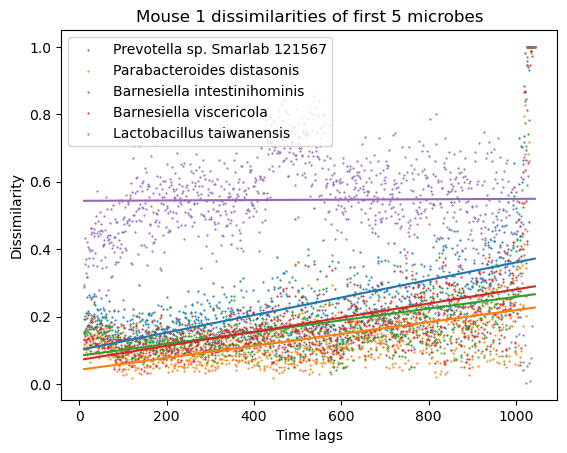

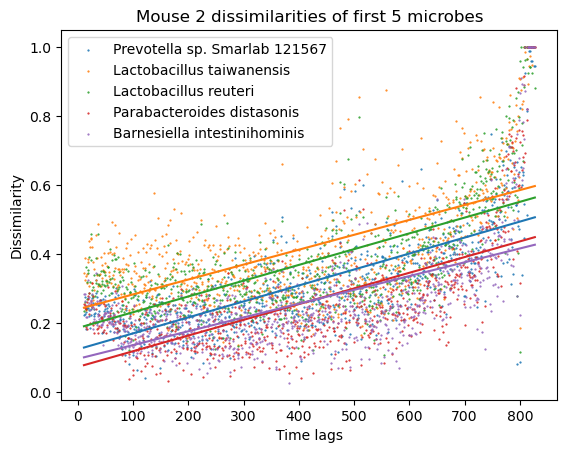

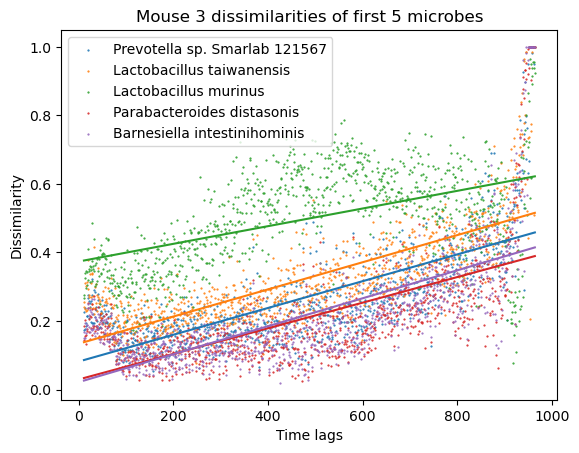

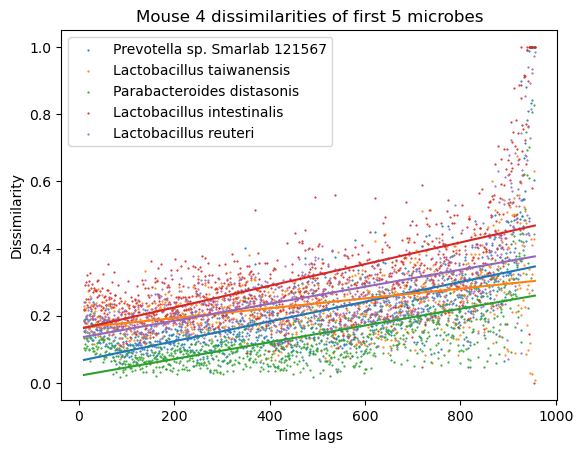

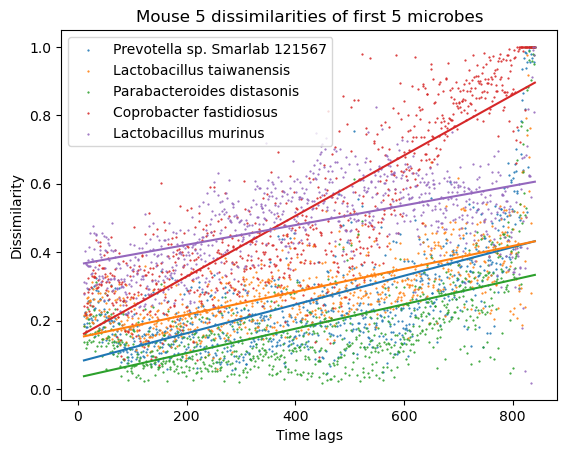

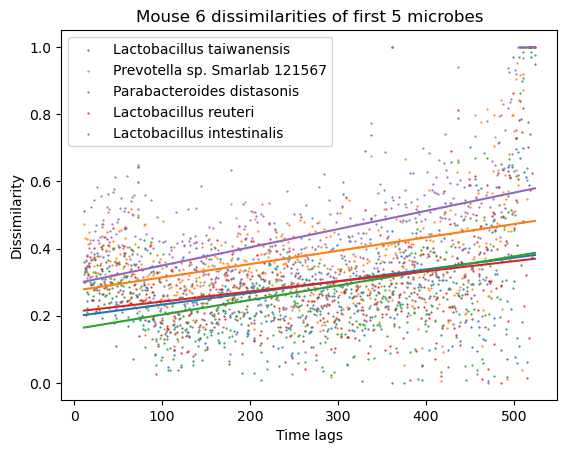

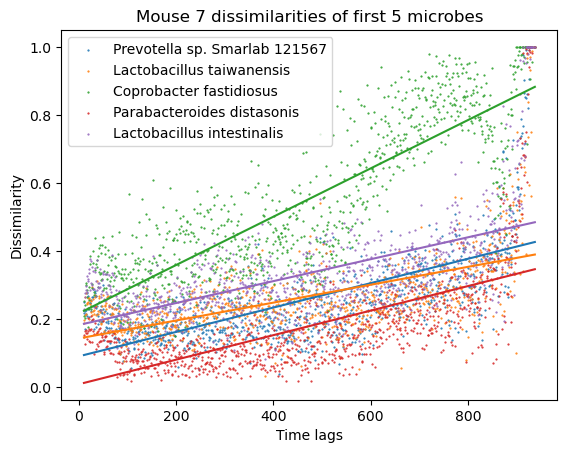

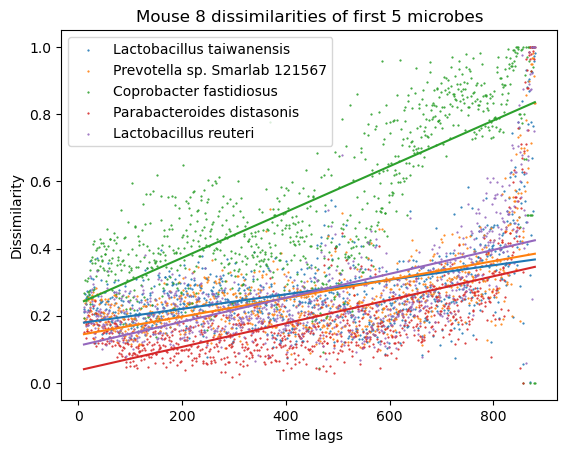

In [22]:
# Perform a linear fit
slopes_species=[]

for idx, mouse_df in enumerate(mice_diss): 
    data = mouse_df.head(5)
    sp_m = []
    sp_q = []
    sp_pred = []
    for sp_idx in range(len(data)): 
        sp_data = np.asarray(data.iloc[sp_idx, :])
        lags = np.asarray(data.columns, dtype = int)
        m, q, *_ = linregress(lags, sp_data)
        pred_data = m*lags + q
        sp_m.append(m)
        sp_q.append(q)
        sp_pred.append(pred_data)
        plt.scatter(lags, sp_data, s = 0.3, label = f'{mouse_df.index[sp_idx]}')
        plt.plot(lags, pred_data)
        plt.xlabel("Time lags")
        plt.ylabel("Dissimilarity")

    slopes_species.append(sp_m)
    plt.title(f"Mouse {idx + 1} dissimilarities of first 5 microbes")
    plt.legend()
    plt.show()
        

## Identify the threshold for increasing curves

"To establish the threshold, we accounted for the fact that, although we
expect a flat dissimilarity if the abundance is stationary, a slope different from zero can be found because of the noise in the estimation of $\Phi$, which depends on the length and density of the time series, on the
sequencing depth, and from the OTU parameters. Therefore, for each individual, we computed the threshold as follows:

1.  We simulated the dynamics of each OTU according to the SLM with parameters equal to the parameters estimated for that OTU and $\tau$ = 1. 

2. From these time series of $\vec{\lambda}$, we sampled the time series of $\vec{x}$ according to the sampling depth of the corresponding samples in the data, obtaining therefore values of $\vec{x}$ only for days for which the individual was sampled. 

3. We then computed $\tilde{\Phi}_i(T)$ and its slope for each
OTU. We defined as threshold for an individual the 95% quantile of
the slopes obtained for that individual, i.e., the value such that only
5% of slopes obtained from the simulation are larger." 

(from the article)

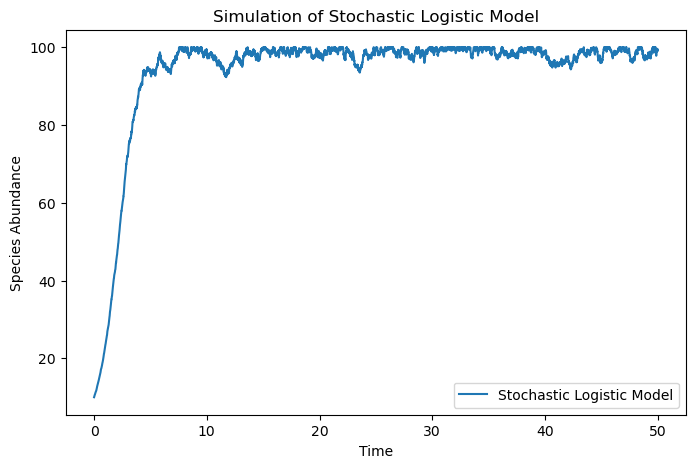

In [17]:
# Fit data of each OTU with SLM to get the parameters estimated for each OTU

def simulate_SLM(ab0, K, sigma, tau, steps, dt): 
    ab_vals = np.zeros(int(steps) + 1) # This is gonna be a vector of abundances at each time t for that species of that mouse
    ab_vals[0] = ab0
    for t in range(1, steps + 1): 
        ab = ab_vals[t-1]
        ab_vals[t] = ab + ( (ab/tau)*(1 - (ab / K)) +  ab * np.sqrt(sigma/tau) * np.random.normal() ) * dt[t-1]
        # Prevent numerical issues
        ab_vals[t] = max(0, min(ab_vals[t], 1*K))  # Ensuring non-negative & not exploding (K is the maximum sustainable population size given the environmental constraints)
    return ab_vals

# Random trial just to see if the function defined above works

#MWMWMWMWMWMWM  Parameters  MWMWMWMWMWMWMWMWMW
ab0 = 10   # Initial population size
K = 100    # Carrying capacity
sigma = 0.1  # Noise intensity
tau = 1.0  # Characteristic time scale
steps = 5000  # Number of steps
dt = np.asarray([0.01]*steps)  # Time step
#MWMWMWMWMWMWMMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMW
# Run simulation
ab_vals = simulate_SLM(ab0, K, sigma, tau, steps, dt)

# Plot results
time_vals = np.linspace(0, steps * dt[0], steps + 1)
plt.figure(figsize=(8, 5))
plt.plot(time_vals, ab_vals, label="Stochastic Logistic Model")
plt.xlabel("Time")
plt.ylabel("Species Abundance")
plt.title("Simulation of Stochastic Logistic Model")
plt.legend()
plt.show()

In [18]:
# Let's now fit this SLM simulation to our empirical time series (remember that data is stored in mice_diss)

# Let's first try with only the first species of the first mice
df = mice_diss[0] # Get the DataFrame of the first mice
species = df.index # Get the species names 
time_series = df.loc[species[0]] # Access the data of the first specie
time_lags = np.asarray(df.columns, dtype = int) # Access the time lag values 
dt = np.diff(time_lags)  #np.asarray([time_lags[i+1] - time_lags[i] for i in range(0, len(time_lags) - 1)])
tau = 1 # Set tau = 1 following the article

# Procedure (requires time_series, dt and tau)
def objective(params, time_series, dt, tau): 
    
    K, sigma = params
    simulated_data = simulate_SLM(ab0 = time_series.iloc[0], 
                                  K = K,
                                  sigma = sigma,
                                  tau = tau, 
                                  steps = len(time_series) - 1, 
                                  dt = dt)
    
    if np.isnan(simulated_data).any():  # Check for NaN values
        return np.inf  # Return a large penalty value
        
    return np.sum((simulated_data - time_series)**2) # Minimize MSE

# Setting bounds for K and sigma
K_min = max(1, time_series.max() / 10)
K_max = 10 * time_series.max()
bounds_K = (K_min, K_max)
sigma_min = 1e-4  # Small but nonzero
sigma_max = 0.5 * time_series.std()  # Half of standard deviation
bounds_sigma = (sigma_min, sigma_max)
bounds = [bounds_K, bounds_sigma] 
result = opt.differential_evolution(objective, bounds, args=(time_series, dt, tau), strategy='best1bin') # Optimize using Differential Evolution

K_opt, sigma_opt = result.x # Extract optimal parameters
print("Estimated K:", K_opt)
print("Estimated sigma:", sigma_opt)


Estimated K: 1.0652031068204728
Estimated sigma: 0.06702432811496893


## Stationarity: 

Distinguish OTUs that have stationary dynamics from the others, visualize in a plot $\Phi_i(T)/\Phi_i^\infty$ vs T.  

In [137]:
K_opt, sigma_opt =100, 0.6 #DA TOGLIERE
df = mi.mice_df[0]


def dissimilarity(simulated_series):
        dissimilarity_data=[]
        days=np.arange(0,len(simulated_series),1)
        valid_day_pairs = {T: {day for day in days if (day + T) in days} for T in range(1, len(simulated_series) + 1)}

# For each species, compute dissimilarities by time lag
        for T in range(1, len(simulated_series) + 1):
                total_diss = 0
                count = 0
                for day in valid_day_pairs[T]:
                    diss_t = ((simulated_series[day] - simulated_series[day + T]) / 
                            max(1, (simulated_series[day] + simulated_series[day + T])))**2
                    total_diss += diss_t
                    count += 1

                # Only store dissimilarities for time lags with valid days
                if count > 0:
                    dissimilarity_data.append(total_diss / count)
                    
        return dissimilarity_data

#########################################
#    time(row of a species for a mouse); K_opt(float), sigma_opt(float)
#   
#    This function compute the treshold for a specific mouse species. 
#    First compute simulate data with best K and best sigma and compute 
#    the slope. To find treshold it take the 95% quantile.
#    The for loop inside the threshold() function simulates data 
#    100 times instead of just once because the function is designed to estimate
#    a threshold based on variability in the simulations. So i get a "list" of slope where I can measure 
#    5% of quartile
#
#########################################

def threshold(time, k_opt, sigma_opt):
    slopes, sim_serie_diss = [], []
    
    num_simulations = 100    
    dt = np.diff(time) 
    

    for i in range((num_simulations)):
        #print(i)
        # Simulate data with best K and sigma
        simulated_series = simulate_SLM(ab0=time[i]+0.001,  # We put 0.001 to don't have zero
                                        K=(k_opt),
                                        sigma=(sigma_opt), 
                                        tau=1.0, 
                                        steps=len(time) - 1,  # Total steps 
                                        dt=dt) 
        
        #We compute the dissimilarity of simulated data; so we can take the 5% of percentile
        simulated_series_diss = dissimilarity(simulated_series)  
        slope, _, _, _, _ = linregress(np.arange(len(simulated_series_diss)), simulated_series_diss)
        slopes.append(slope)
        
    threshold_value = np.percentile(slopes, 5) 
    return threshold_value


# Main loop to calculate the trend for each species of every mouse

df_start_point=df.iloc[:,14]  #ORA VALE SOLO PER TOPO 1; da cambiare

for mouse in mice_diss:
    #Delete TREND column if you want to RERUN code
    if 'TREND' in mouse.columns:
        mouse.drop('TREND', axis=1, inplace=True)
        
    # Calculate the threshold for the current species
    threshold_mouse = threshold(df_start_point, K_opt, sigma_opt)
        
    ####################
    print(f"Processing mouse")
    ####################
    trend = []
    
    # Convert the species index to string (if needed)
    species = mouse.index.astype(str)
    c=-1
    for spec in species:      
        c+=1
        time_diss = mouse.loc[spec]        
        
        # Calculate the slope for real data (excluding the transient phase)
        slope_mouse, _, _, _, _ = linregress(np.arange(len(time_diss)), time_diss)
        
        # Compare the slope with the threshold to determine the trend
        if slope_mouse > threshold_mouse:
            trend.append("incr")  # Increasing
        else:
            trend.append("flat")  # Flat
    
    # Add the trend as a new column in the mouse DataFrame
    mouse["TREND"] = trend
    
    # Print or save the trends for the current mouse
    print(f"Trends for mouse {c} appended to his dataframe")
    break
    
####    !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#### NEL DATABASE HO APPESO COME ULTIMA COLONNA IL TREND (DA VALUTARE SE é COMODO)
####    !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
1.226532691110181e-09
Processing mouse
Trends for mouse 625 appended to his dataframe


The number of flat species is: 294, so it is the:46.96485623003195%
The number of flat species is: 332, so it is the:53.03514376996805%


C:\Users\lucaf\AppData\Local\Temp\ipykernel_3632\3408354968.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flat=size[0]/(size[0]+size[1])
C:\Users\lucaf\AppData\Local\Temp\ipykernel_3632\3408354968.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  incr=size[1]/(size[0]+size[1])
C:\Users\lucaf\AppData\Local\Temp\ipykernel_3632\3408354968.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"The number of flat species is:

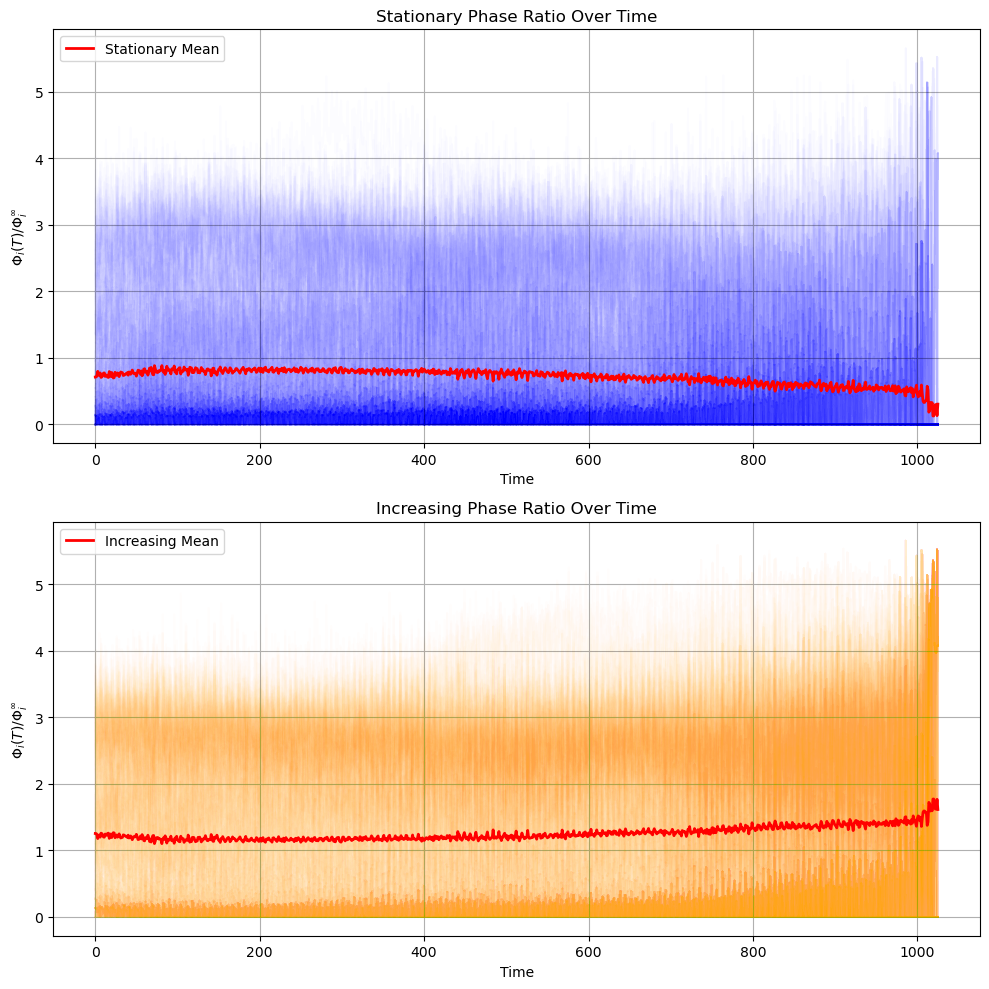

In [138]:

for mice in mice_diss:    

    size= mouse.groupby("TREND").size()
    flat=size[0]/(size[0]+size[1])
    incr=size[1]/(size[0]+size[1])
    print(f"The number of flat species is: {size[0]}, so it is the:{flat*100}%")
    print(f"The number of increasing species is: {size[1]}, so it is the:{incr*100}%")
    
    phi_inf=np.mean(mouse.iloc[:, :-1], axis=0)  
    ratio = mouse.iloc[:, :-1] / (phi_inf + 1e-4)  

    stationary_mask = (mouse["TREND"]=="flat") 
    ratio_stationary=pd.DataFrame(ratio[stationary_mask])

    increasing_mask = (mouse["TREND"]=="incr") 
    ratio_increasing=pd.DataFrame(ratio[increasing_mask])
    
    mean_ratio_stationary = ratio_stationary.mean(axis=0)
    mean_ratio_increasing = ratio_increasing.mean(axis=0)


    figure, axis = plt.subplots(2, 1, figsize=(10, 10))

    # --- Plot 1: Stationary Trend ---
    time_points = np.arange(0, len(mean_ratio_stationary), 1)
    for i in range(len(ratio_stationary)):        
        axis[0].plot(time_points, ratio_stationary.iloc[i], color='b', alpha=0.01)  # Light blue individual lines

    axis[0].plot(time_points, mean_ratio_stationary, label="Stationary Mean", color='red', linewidth=2)  # Bold mean line

    axis[0].set_xlabel("Time")
    axis[0].set_ylabel("$\\Phi_i(T)/\\Phi_i^\\infty$")
    axis[0].set_title("Stationary Phase Ratio Over Time")
    axis[0].legend()
    axis[0].grid(True)

    # --- Plot 2: Increasing Trend ---
    for i in range(len(ratio_increasing)):        
        axis[1].plot(time_points, ratio_increasing.iloc[i], color='orange', alpha=0.01)  # Light green individual lines

    axis[1].plot(time_points, mean_ratio_increasing, label="Increasing Mean", color='red', linewidth=2)  # Bold mean line

    axis[1].set_xlabel("Time")
    axis[1].set_ylabel("$\\Phi_i(T)/\\Phi_i^\\infty$")
    axis[1].set_title("Increasing Phase Ratio Over Time")
    axis[1].legend()
    axis[1].grid(True)

    # Show the plots
    plt.tight_layout()
    plt.show()

    break  #DA TOGLIERE

##DA FARE PER TUTTI I TOPI; DA SALVARE LE IMMAGINI 


## WHAT DO YOU THINK OF THESE RESULTS? WHAT DO YOU THINK ABOUT THE IMPOSED BOUNDS? I'M NOT SO SURE AND IDK IF MAYBE WE SHOULD USE CURVE_FIT INSTEAD OF THIS

In [ ]:
# Sample counts for days for which the individual was sampled

In [ ]:
# Compute the dissimilarity for the simulated data 



In [ ]:
# Compute the slope obtained for the dissimilarity of simulated data

In [ ]:
# Compute the treshold for each individual as the 95% quantile of the slopes obtained for that individual

Perform a taxonomic analysis on species with nonstationary behaviour (common classifications or something else)

## Estimate the parameters of SLM for stationary species

estimate the model parameters $K$ and $\sigma$, from the relations $\left<\lambda\right>=K\left(\frac{2-\sigma}{2}\right)$ and $Var(\lambda)= \left( \frac{\sigma}{2-\sigma} \right) \left<\lambda\right>^2$

        - if $\sigma<2$, the stationary distribution is gamma $$P(\lambda; K, \sigma) = \frac{1}{\Gamma (2/\sigma -1)} \left(\frac{2}{\sigma K}\right)^{2/\sigma -1} \lambda^{2/\sigma-2} e^{-\frac{2}{\sigma K}\lambda} $$
        so we can produce a histogram out of our data and superimpose the theoretical pdf; perform test on distribution

        calculate theoretical expectation value for the dissimilarity at stationarity $\mathbb{E}[\Phi_i^\infty]=\frac{\sigma}{4-\sigma}$, compare with the data.
